In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ResNet, ConvNext, ViT

import trainer as train_funct
from trainer import Trainer

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = SummaryWriter()

In [3]:
train_funct.set_seed(42)

## Dataset

In [4]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [5]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [6]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 32875
Validation: 4000
Test: 4000


In [7]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [8]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


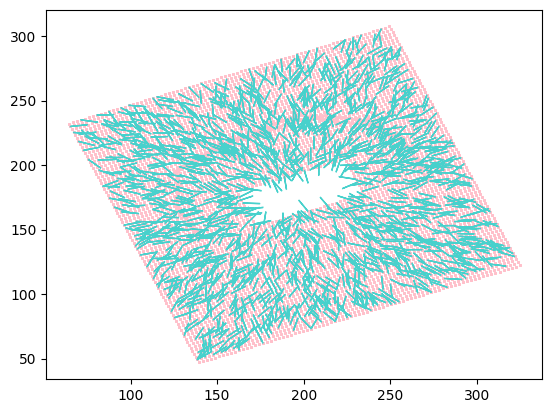

In [9]:
plotter.plot_train_data(train_data)

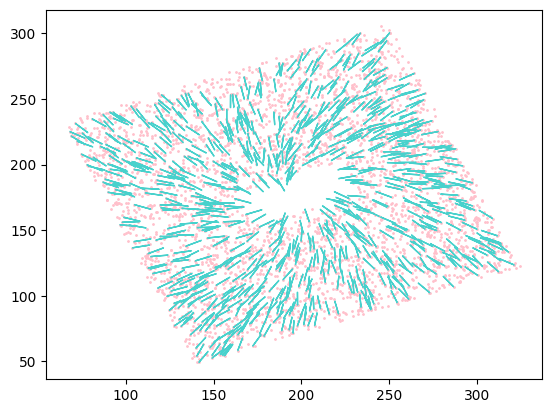

In [10]:
plotter.plot_data(val_data)

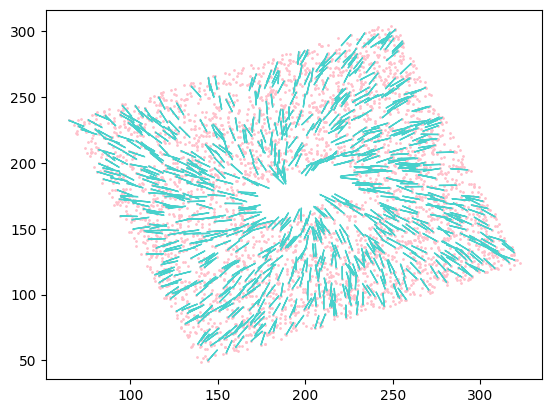

In [11]:
plotter.plot_data(test_data)

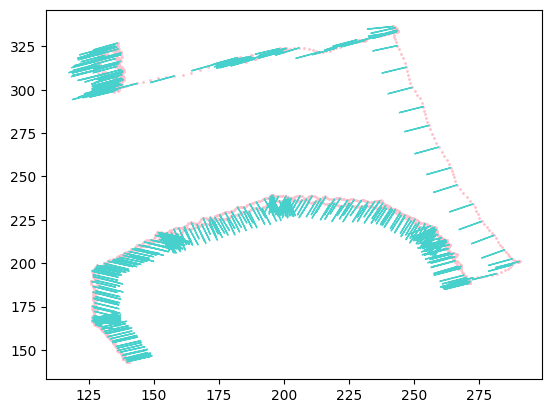

In [12]:
plotter.plot_data(real_data)

In [13]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Training before filtering: 32875


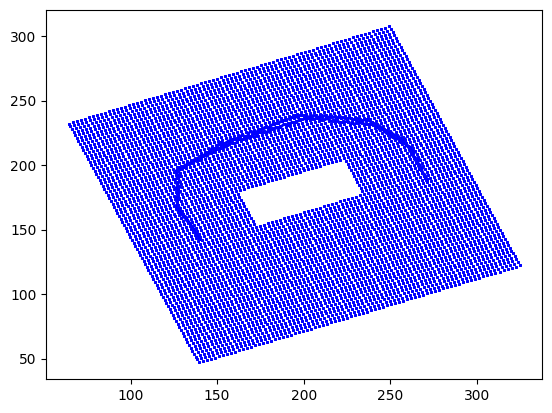

In [14]:
plotter.plot_synth_poses_train(train_data, "blue")
print("Training before filtering: " + str(len(train_data.imgs)))

Filtering poses: 100%|████████████████| 32875/32875 [00:00<00:00, 371504.86it/s]


Train after filtering: 28060


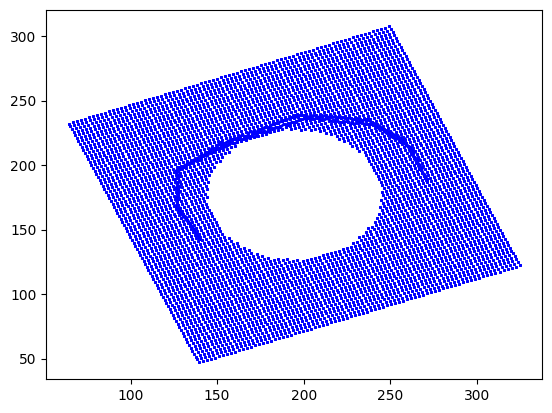

In [15]:
visualizer.filter_train_data(train_data)

plotter.plot_synth_poses_train(train_data, "blue")

print("Train after filtering: " + str(len(train_data.imgs)))

Validation before filtering: 4000


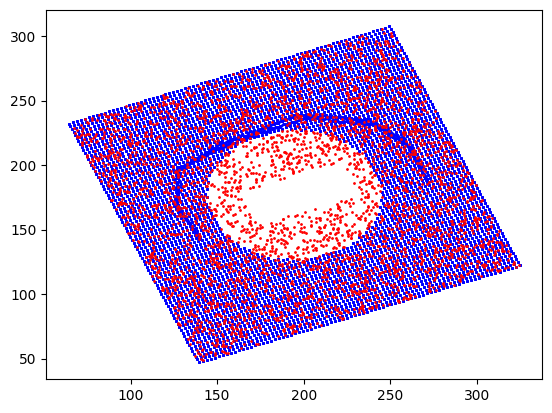

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1785.50it/s]


Validation after filtering: 3490


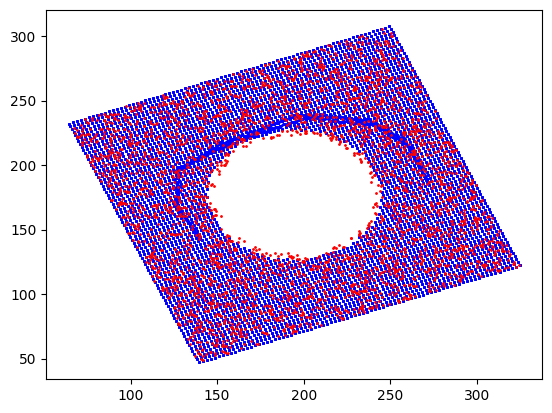

In [17]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


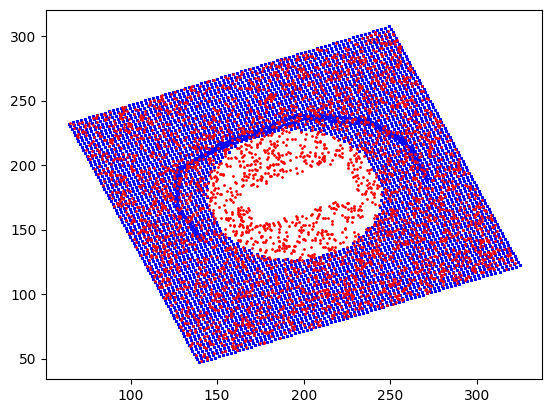

In [18]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1798.59it/s]


Test after filtering: 3502


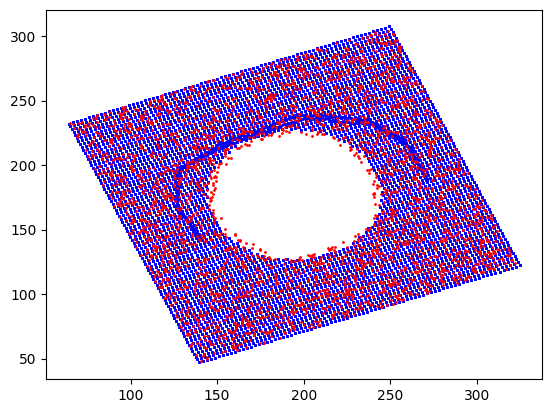

In [19]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 1.0
yaw difference tensor(0.) deg
localization error:  0.0 meters


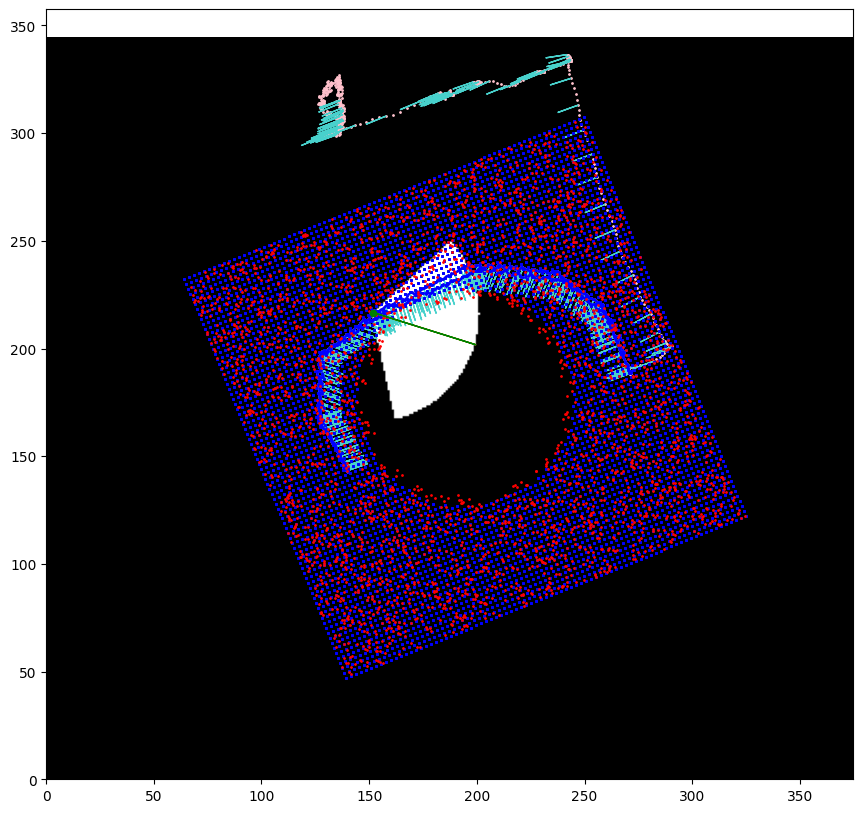

<Figure size 640x480 with 0 Axes>

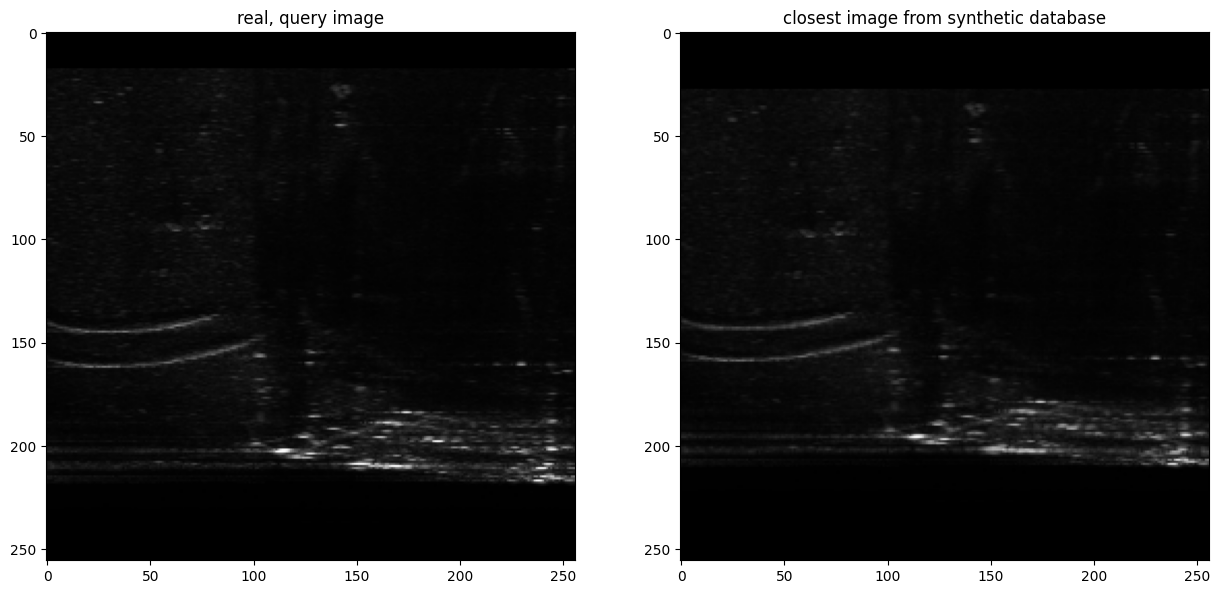

In [20]:
visualizer.localization(train_data, val_data, real_data)

In [21]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 28060
Validation: 3490
Test: 3502


In [22]:
val_data = visualizer.check_gt(train_data, val_data)

In [23]:
test_data = visualizer.check_gt(train_data, test_data)

In [24]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 28060
Validation: 3437
Test: 3455


In [25]:
model_name = "ConvNext_r"

In [26]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [27]:
net = ConvNext.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [28]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [29]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  2445233


## Training Pipeline

### Train epochs

In [30]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|███████████████████████████████████████| 1754/1754 [12:12<00:00,  2.39it/s]


train loss mean: 4616012.601691612
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:37<00:00, 286.66it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:13<00:00, 263.11it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:42<00:00,  7.43it/s]


average localization error: 2.7394 meters
average orientation error : 24.6416 degrees
epoch: 2


100%|███████████████████████████████████████| 1754/1754 [12:00<00:00,  2.43it/s]


train loss mean: 14.057626000288003
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:36<00:00, 290.68it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:12<00:00, 284.85it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:40<00:00,  7.47it/s]


average localization error: 2.6598 meters
average orientation error : 23.7420 degrees
epoch: 3


100%|███████████████████████████████████████| 1754/1754 [11:41<00:00,  2.50it/s]


train loss mean: 1.866422448829751
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:35<00:00, 295.36it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:11<00:00, 286.98it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:42<00:00,  7.43it/s]


average localization error: 2.6096 meters
average orientation error : 22.6254 degrees
epoch: 4


100%|███████████████████████████████████████| 1754/1754 [15:10<00:00,  1.93it/s]


train loss mean: 0.22743843151776794
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:38<00:00, 286.02it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:12<00:00, 281.59it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:41<00:00,  7.45it/s]


average localization error: 2.0872 meters
average orientation error : 17.4727 degrees
epoch: 5


100%|███████████████████████████████████████| 1754/1754 [11:46<00:00,  2.48it/s]


train loss mean: 0.1265447318655871
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:34<00:00, 295.57it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:11<00:00, 297.41it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:43<00:00,  7.42it/s]


average localization error: 2.5894 meters
average orientation error : 22.7998 degrees
epoch: 6


100%|███████████████████████████████████████| 1754/1754 [11:40<00:00,  2.50it/s]


train loss mean: 0.0765302997876804
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:49<00:00, 255.31it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:14<00:00, 240.85it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [08:03<00:00,  7.11it/s]


average localization error: 2.0464 meters
average orientation error : 16.6854 degrees
epoch: 7


100%|███████████████████████████████████████| 1754/1754 [11:42<00:00,  2.50it/s]


train loss mean: 0.03172578402458262
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:51<00:00, 250.96it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:12<00:00, 265.37it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:45<00:00,  7.38it/s]


average localization error: 2.0981 meters
average orientation error : 16.9275 degrees
epoch: 8


100%|███████████████████████████████████████| 1754/1754 [11:51<00:00,  2.46it/s]


train loss mean: 0.028041497333784467
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:48<00:00, 258.18it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:12<00:00, 268.02it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:43<00:00,  7.42it/s]


average localization error: 2.1504 meters
average orientation error : 16.2608 degrees
epoch: 9


100%|███████████████████████████████████████| 1754/1754 [11:37<00:00,  2.51it/s]


train loss mean: 0.0299105665889678
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:37<00:00, 287.33it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:12<00:00, 284.17it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:43<00:00,  7.41it/s]


average localization error: 2.1590 meters
average orientation error : 16.2870 degrees
epoch: 10


100%|███████████████████████████████████████| 1754/1754 [11:45<00:00,  2.48it/s]


train loss mean: 0.024271606168727748
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:36<00:00, 290.54it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:11<00:00, 290.48it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:54<00:00,  7.25it/s]


average localization error: 2.0075 meters
average orientation error : 14.7012 degrees
epoch: 11


100%|███████████████████████████████████████| 1754/1754 [12:32<00:00,  2.33it/s]


train loss mean: 0.017887819645992196
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:43<00:00, 272.19it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:12<00:00, 266.08it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:41<00:00,  7.44it/s]


average localization error: 1.9365 meters
average orientation error : 14.1470 degrees
epoch: 12


100%|███████████████████████████████████████| 1754/1754 [11:34<00:00,  2.52it/s]


train loss mean: 0.014665164103882309
computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:39<00:00, 282.52it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:12<00:00, 280.39it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3437/3437 [07:42<00:00,  7.44it/s]


average localization error: 1.9439 meters
average orientation error : 14.1266 degrees
Training time:  15685.075026273727 seconds


In [31]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

Inference time per image:  0.0010441988706588745 seconds


In [32]:
input_tensor = next(iter(train_dataloader))[0].cuda()
inference_memory_per_batch = metrics.inference_memory(net, input_tensor)
print("Inference memory for batch: ", inference_memory_per_batch, "MB")

Inference memory for batch:  140.80224609375 MB


In [33]:
metrics.get_descriptors(train_data, val_data, net)

100%|████████████████████████████████████| 28060/28060 [01:41<00:00, 276.90it/s]


computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:38<00:00, 286.09it/s]
/home/firp/Desktop/Notebook_bsd/metrics.py:92: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_pred_embeds = torch.Tensor(train_data.descriptors)


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3437/3437 [00:11<00:00, 287.97it/s]


descriptors computed!
torch.Size([3437]) torch.Size([3437, 5])
avg_metric_e     : tensor(114.9799)
avg_metric_e_top5: tensor(53.1386)


## Visualize Training results on Test data

### Load the checkpoint model

In [34]:
checkpoint_path = best_model_path
print("Best model path: ", best_model_path)
net = ConvNext.Model()
train_funct.load_state(net, checkpoint_path)

net = net.cuda()
net.eval();

Best model path:  correct_model_3/epoch_11.pth


### Compute the final descriptors of the training data

### Query the database

In [35]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|████████████████████████████████████| 28060/28060 [01:34<00:00, 298.03it/s]

descriptors computed!


### Visualize query results: sonar images

In [36]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 32, 64, 64]) tensor(-0.3714, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3511, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 32, 32]) tensor(-0.5079, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5300, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 16, 16]) tensor(-0.6455, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9030, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 256, 8, 8]) tensor(-0.5414, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5339, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.4857, device='cuda:0', grad_fn=<MinBackward1>) tensor(-0.4850, device='cuda:0', grad_fn=<MaxBackward1>)


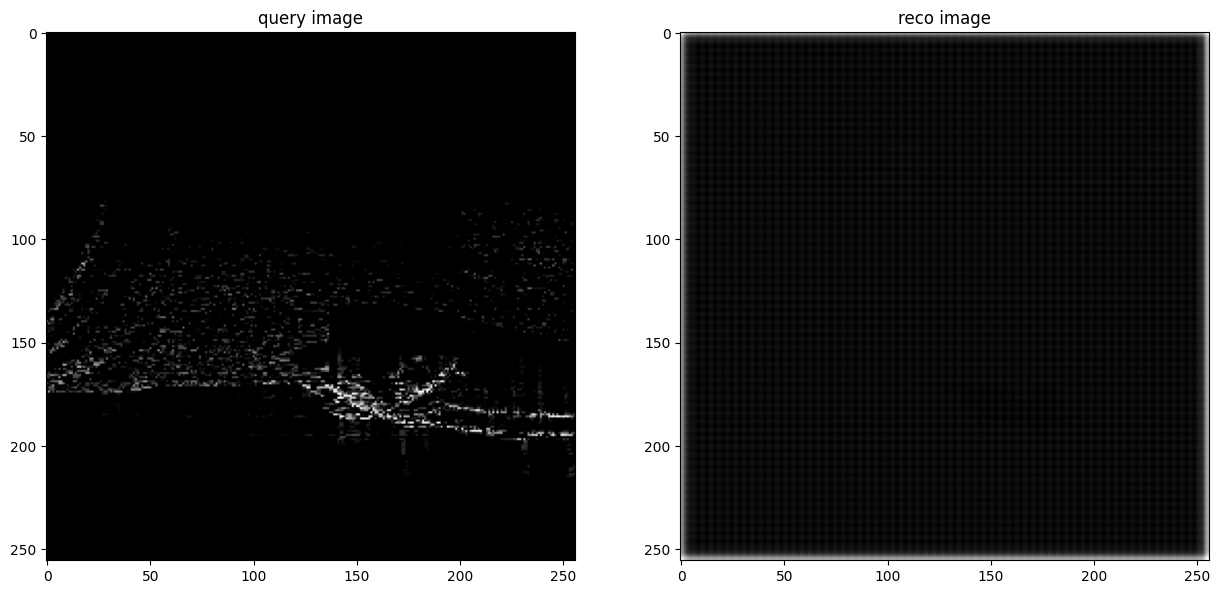

In [37]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.5293022938612827
localization error: 3.2882 meters
orientation error : 16.8994 degrees


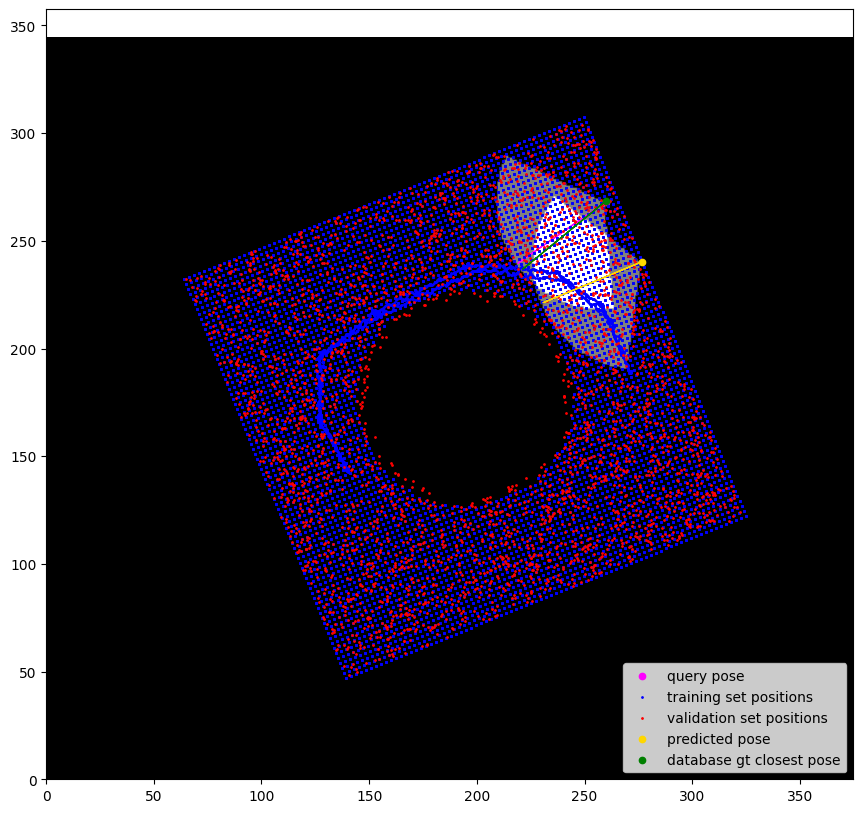

<Figure size 640x480 with 0 Axes>

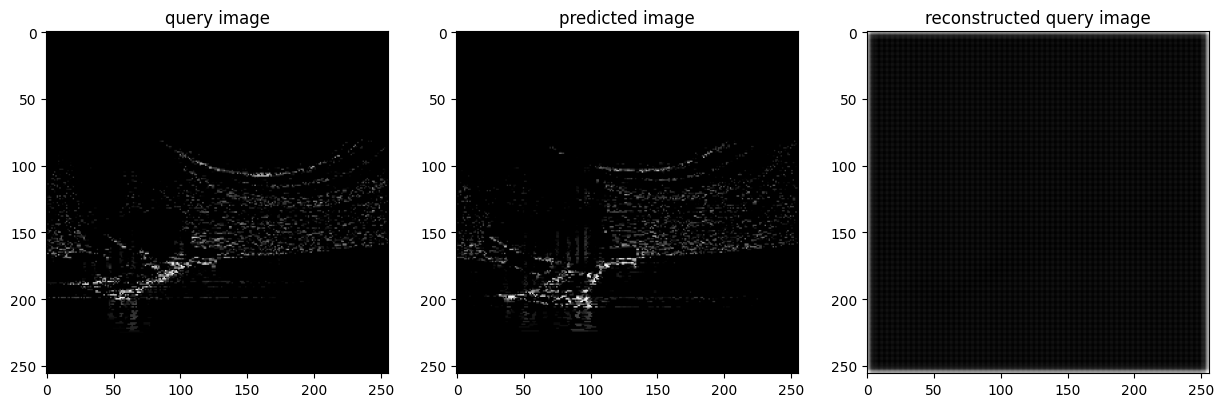

In [38]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [39]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

100%|███████████████████████████████████████| 3455/3455 [07:49<00:00,  7.37it/s]

average localization error: 2.0030 meters
average orientation error : 14.6808 degrees


In [40]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [41]:
loca_errors.argmax()

np.int64(1973)

In [42]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

1.3120692
3.7904623


## Process real images

query_idx: 281
195.32013 237.99988 0.15199065 -171.29156
iou: 0.9622824347796091
localization error Upper:  0.04533045 meters


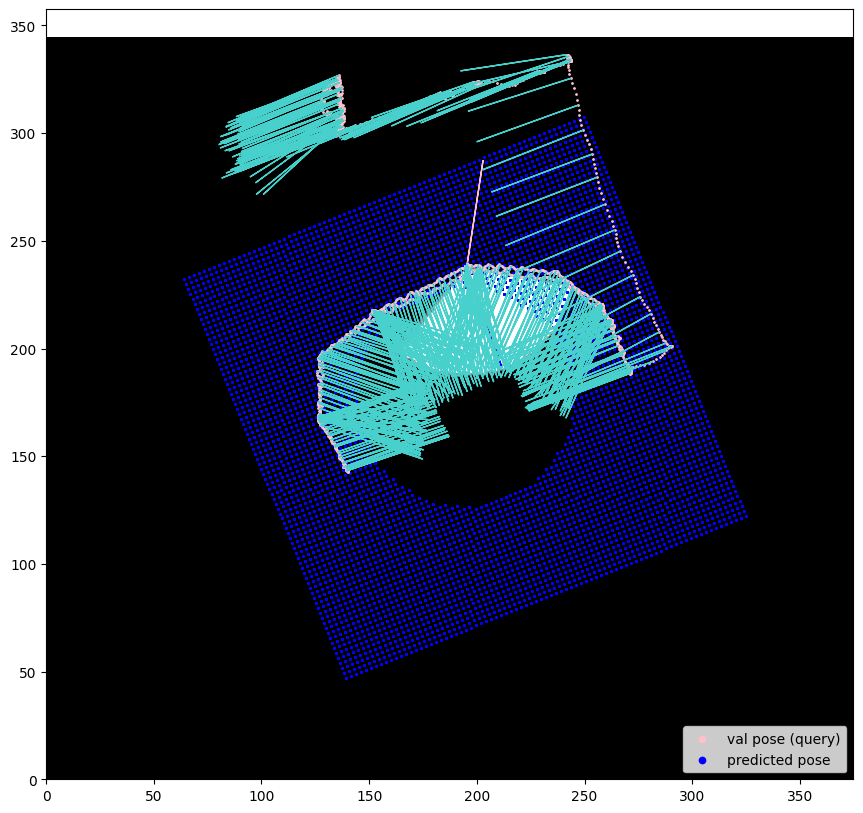

<Figure size 640x480 with 0 Axes>

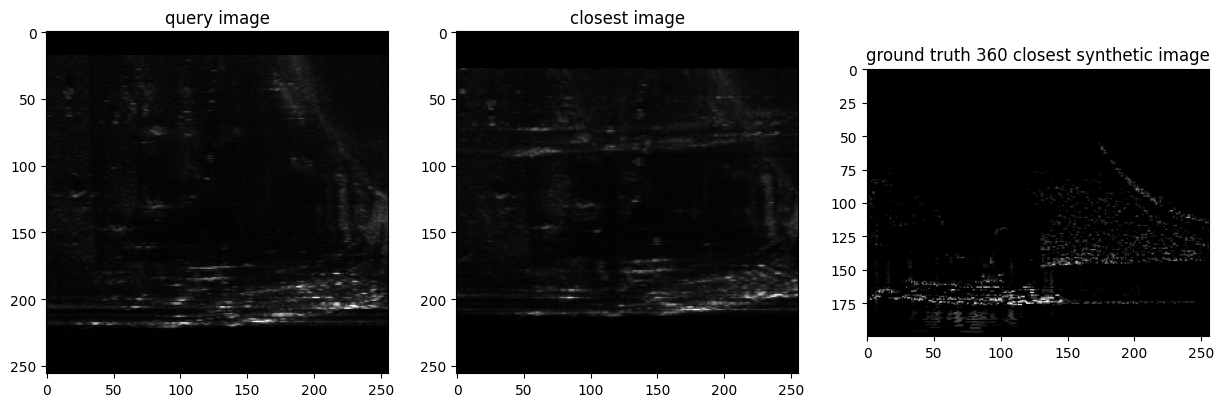

In [43]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [44]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [45]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|████████████████████████████████████████| 710/710 [00:02<00:00, 249.01it/s]

descriptors computed!


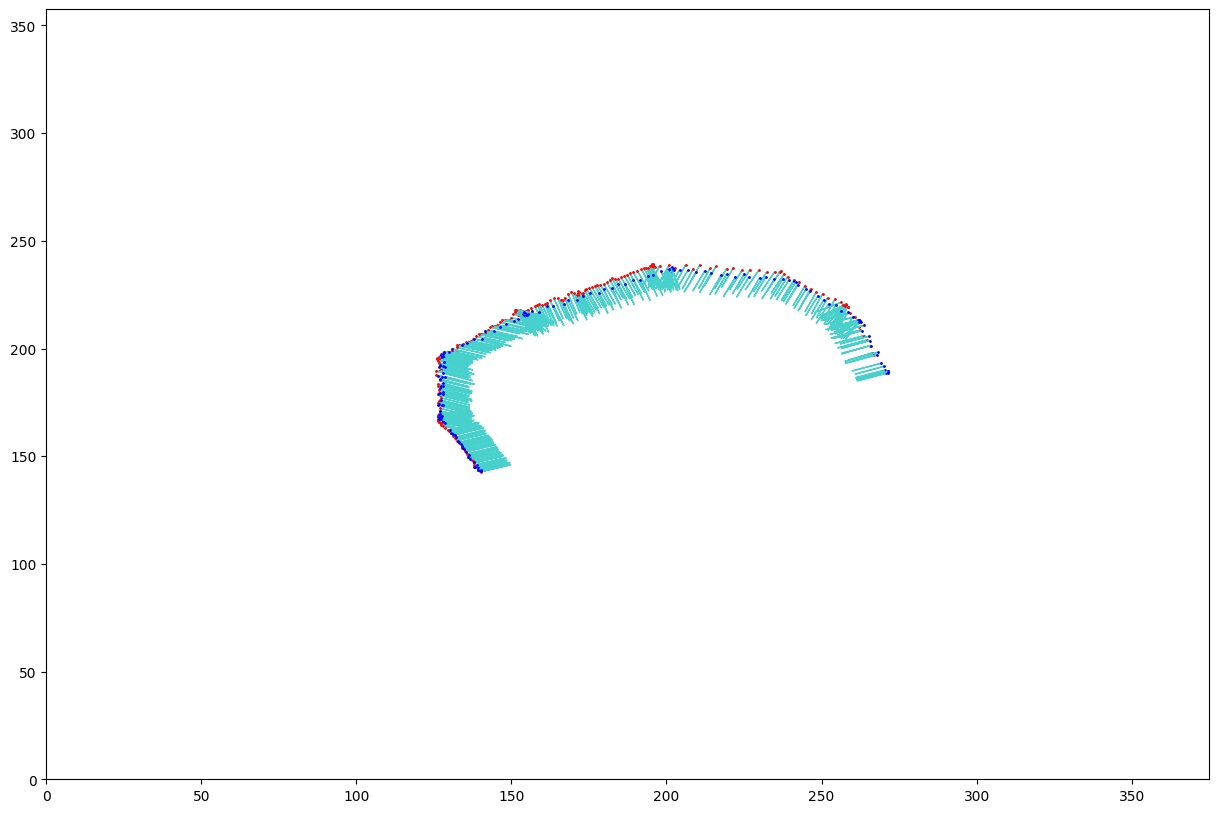

In [46]:
visualizer.visualize_real(train_data, real_data)

731
iou: 0.8515121417876359
localization error: 0.1669 meters
orientation error : 2.0569 degrees


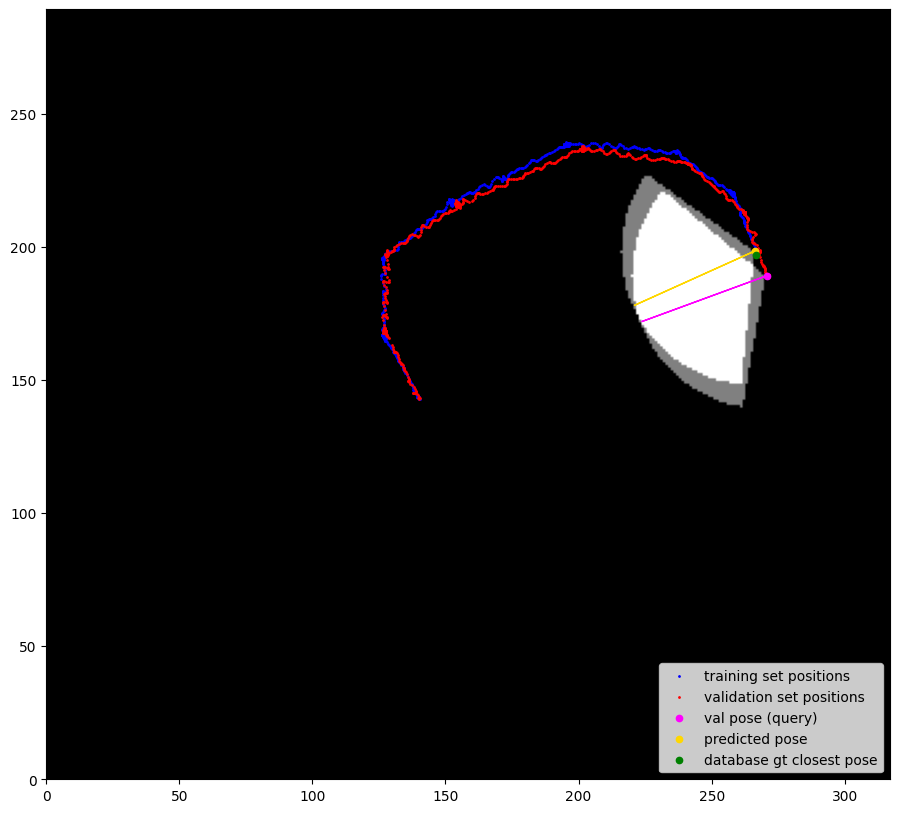

<Figure size 640x480 with 0 Axes>

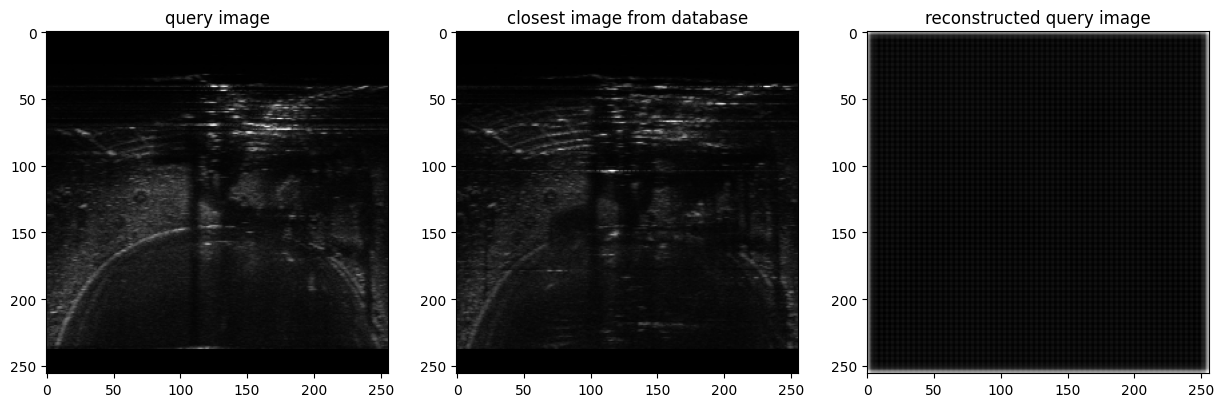

In [47]:
query_idx = random.randint(700, len(real_data_valid))
print(query_idx)
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [48]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:14<00:00, 52.61it/s]

average localization error: 0.7974 meters
average orientation error : 10.7512 degrees


In [49]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [50]:
avg_orie_error.min()

np.float32(10.751174)

In [51]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

0.7973829
1.7187121


## Results

In [52]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, inference_memory_per_batch, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Inference memory per batch: {inference_memory_per_batch:6.4f} MB")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")

Model name: ConvNext_r
Total parameters: 2445233
Training time: 15685.0750 seconds
Inference time per image: 0.0010 seconds
Inference memory per batch: 140.8022 MB
Average localization error in Test: 2.0030 meters
Average orientation error in Test: 14.6808 degrees
Average localization error in Real: 0.7974 meters
Average orientation error in Real: 10.7512 degrees
